In [4]:
import sys
sys.path.append('../')
import torch
from tools.utils import manual_seed
import PIL
import PIL.Image

import numpy as np
import matplotlib.pyplot as plt
from tools.img import rgb2yuv, yuv2rgb, rgb_to_yuv, yuv_to_rgb
from torchvision.transforms.transforms import ToTensor
from tools.dataset import get_dataloader, get_dataset_class_and_scale, get_dataset_normalization, get_de_normalization
from omegaconf import OmegaConf
from tools.img import tensor2ndarray, ndarray2tensor
from torchmetrics import StructuralSimilarityIndexMeasure
from tools.dataset import get_dataloader
from tools.inject_backdoor import patch_trigger

manual_seed(42)

In [5]:
target_folder = '../' + 'results/cifar10/inba/20241009095840_wind8'
path = f'{target_folder}/config.yaml'
config = OmegaConf.load(path)
manual_seed(config.seed)

device = f'cuda:{config.device}'
num_class, scale = get_dataset_class_and_scale(config.dataset_name)
if config.model == "resnet18":
    from models.preact_resnet import PreActResNet18
    net = PreActResNet18(num_classes=num_class).to(f'cuda:{config.device}')
elif config.model == "rnp":
    from models.resnet_cifar import resnet18
    net = resnet18(num_classes=num_class).to(f'cuda:{config.device}')
elif config.model == "repvgg":
    from repvgg_pytorch.repvgg import RepVGG
    net = RepVGG(num_blocks=[2, 4, 14, 1], num_classes=num_class, width_multiplier=[1.5, 1.5, 1.5, 2.75]).to(device=f'cuda:{config.device}')
else:
    raise NotImplementedError(config.model)
ld = torch.load(f'{target_folder}/results.pth', map_location=device)
net.load_state_dict(ld['model'])
net.to(device)

PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d

Load a example image and plot RGB channels.

Convert the RGB image to YUV channels, and plot them.

Use INBA to add pertubation to the imaginary part of U channel after FFT.

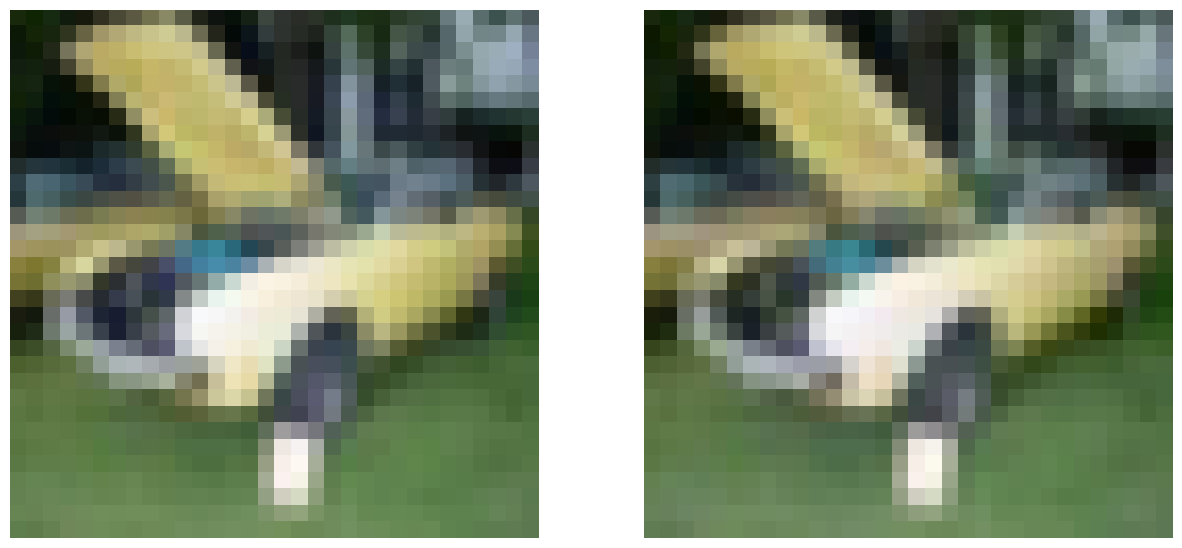

ssim: 0.9927278161048889
1
0
tensor([[-1.5926, -1.7513, -1.6243,  ..., -1.0210, -0.5288, -0.7987],
        [-1.7990, -1.6719, -1.6084,  ..., -0.1636,  0.3762, -0.3383],
        [-1.7990, -1.7513, -1.4497,  ...,  0.4556,  0.5032, -0.1478],
        ...,
        [-0.4018, -0.3542, -0.3383,  ..., -0.4494, -0.4335, -0.5447],
        [-0.3542, -0.3383, -0.2907,  ..., -0.3859, -0.4177, -0.5288],
        [-0.4812, -0.4812, -0.3859,  ..., -0.5129, -0.4812, -0.5288]],
       device='cuda:0')
----------
tensor([[0.0980, 0.0588, 0.0902,  ..., 0.2392, 0.3608, 0.2941],
        [0.0471, 0.0784, 0.0941,  ..., 0.4510, 0.5843, 0.4079],
        [0.0471, 0.0588, 0.1333,  ..., 0.6039, 0.6157, 0.4549],
        ...,
        [0.3922, 0.4039, 0.4079,  ..., 0.3804, 0.3843, 0.3569],
        [0.4039, 0.4079, 0.4196,  ..., 0.3961, 0.3882, 0.3608],
        [0.3726, 0.3726, 0.3961,  ..., 0.3647, 0.3726, 0.3608]],
       device='cuda:0', grad_fn=<SelectBackward0>)


tensor(-0.6548, device='cuda:0', grad_fn=<MeanBackward0>)

In [6]:
_, test_dl = get_dataloader(config.dataset_name, config.batch, False, 11)
x_c = None
for batch, label in test_dl:
    for i in range(batch.shape[0]):
        if label[i] == 1:
            x_c = batch[i]
            break
x_c = get_de_normalization(config.dataset_name)(x_c).squeeze()
x_p = patch_trigger(x_c, config)

_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(tensor2ndarray(x_c))
ax[0].axis('off')
ax[1].imshow(tensor2ndarray(x_p))
ax[1].axis('off')
plt.show()
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0)(x_c.unsqueeze(0), x_p.unsqueeze(0))
print(f'ssim: {ssim_metric}')


x_p = patch_trigger(x_c, config)
x_c = get_dataset_normalization(config.dataset_name)(x_c)


# when training, we do not perform normalization to poison images, which is the same as BackdoorBench.

x_c = x_c.to(device)
x_p = x_p.to(device)

if config.model == 'repvgg':
    net.deploy = True
net.eval()
with torch.no_grad():
    out_c = net(x_c.unsqueeze(0))
    out_p = net(x_p.unsqueeze(0))
    _, y_c = torch.max(out_c, 1)
    _, y_p = torch.max(out_p, 1)

print(y_c.item())
print(y_p.item())
print(x_c[0])
print('----------')
print(x_p[0])

(x_c - x_p).mean()